In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import nltk, re
import string
import os, gc
import random

tqdm.pandas()

base_dir = "/content/drive/Shareddrives/602Project/Assigns"
os.listdir(base_dir)

['dataset.zip',
 'imdb_movies_raw.csv.gz',
 'imdb_reviews_raw.csv.gz',
 'word2vec.gensim',
 'lda.gensim.state',
 'lda.gensim',
 'lda.gensim.expElogbeta.npy',
 'lda.gensim.id2word',
 'imdb_movies_train.csv.gz',
 'imdb_reviews_train.csv.gz',
 'imdb_movies_val.csv.gz',
 'imdb_movies_test.csv.gz',
 'imdb_reviews_val.csv.gz',
 'imdb_reviews_test.csv.gz']

In [ ]:
rev_train = pd.read_csv(f"{base_dir}/imdb_reviews_train.csv.gz", compression="gzip")
rev_val = pd.read_csv(f"{base_dir}/imdb_reviews_val.csv.gz", compression="gzip")
rev_test = pd.read_csv(f"{base_dir}/imdb_reviews_test.csv.gz", compression="gzip")
print("Reviews data:")
print(rev_train.shape, rev_train.columns)
print(rev_val.shape)
print(rev_test.shape)

Reviews data:
(507092, 11) Index(['username', 'rating', 'helpful', 'total', 'date', 'title', 'review',
       'year', 'name', 'emojis', 'review_words'],
      dtype='object')
(142432, 11)
(142018, 11)


1. Naive Bayes
2. Logistic Regression
3. SVM Linear
4. Random Forest Classifier
5. Boosting Classifier

Reference: Supervised learning. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/supervised_learning.html 

In [ ]:
def get_target_var(x):
    
    if x < 5:
        return "Negative"
    
    elif x>=5 and x <= 7:
        return "Neutral"
    
    elif x >= 8:
        return "Positive"
    
    return x


def reformat_data(rev_df):
    
    rev_df = rev_df.dropna(subset=['review_words']).reset_index(drop=1)
    rev_df['review_words'] = rev_df['review_words'].str.split(r"\|")
    rev_df['review_words'] = rev_df['review_words'].str.join(" ")
    rev_df['sentiment'] = rev_df['rating'].apply(get_target_var)
    return rev_df


rev_train = reformat_data(rev_train)
rev_val = reformat_data(rev_val)
rev_test = reformat_data(rev_test)

rev_train.shape, rev_val.shape, rev_test.shape

((507092, 12), (142432, 12), (142018, 12))

In [ ]:
X_train_full = rev_train['review_words'].values
y_train_full = rev_train['sentiment'].values
rev_train = rev_train.sample(frac=0.4)
rev_train.shape

(202837, 12)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.005, max_df=0.97, ngram_range=(1,2))

X_train_tfidf = tfidf.fit_transform(rev_train['review_words'])
X_val_tfidf = tfidf.transform(rev_val['review_words'])
X_test_tfidf = tfidf.transform(rev_test['review_words'])
X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape

((202837, 3418), (142432, 3418), (142018, 3418))

In [ ]:
y_train = rev_train['sentiment'].values
y_val = rev_val['sentiment'].values
y_test = rev_test['sentiment'].values
rev_train['sentiment'].value_counts()

Positive    117035
Neutral      46936
Negative     38866
Name: sentiment, dtype: int64

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

all_classifiers = { 'naive_bayes': MultinomialNB(),
                   'logistic': LogisticRegression(solver="saga", n_jobs = -1), 
                   'svm_linear': LinearSVC(max_iter=10**4),
                   'random_forest': RandomForestClassifier(n_jobs = -1),
                   # 'gradient_boosting':GradientBoostingClassifier(),
                   'lightgbm': LGBMClassifier(verbose=-1, n_jobs = -1)
                  }

In [ ]:
from sklearn import metrics

val_acc = {}
test_acc = {}
# iterate over classifiers
for key in all_classifiers:
    print('-'*50)
    print('Training {} Model:'.format(key))
    clf = all_classifiers[key]
    clf.fit(X_train_tfidf, y_train)
    all_classifiers[key] = clf
    
    # get predictions & metrics on validation data
    y_val_pred = clf.predict(X_val_tfidf)
    acc = metrics.accuracy_score(y_val, y_val_pred)
    f1 = metrics.f1_score(y_val, y_val_pred, average='weighted')
    print(f'Validation --> Accuracy={round(acc,3)}  F1-score={round(f1,3)}', )
    val_acc[key] = acc

    # get predictions & metrics on test data
    y_test_pred = clf.predict(X_test_tfidf)
    acc = metrics.accuracy_score(y_test, y_test_pred)
    f1 = metrics.f1_score(y_test, y_test_pred, average='weighted')
    print(f'Test Data --> Accuracy={round(acc,3)}  F1-score={round(f1,3)}', )
    test_acc[key] = acc
    print("Done.")

--------------------------------------------------
Training naive_bayes Model:
Validation --> Accuracy=0.69  F1-score=0.638
Test Data --> Accuracy=0.685  F1-score=0.63
Done.
--------------------------------------------------
Training logistic Model:
Validation --> Accuracy=0.755  F1-score=0.746
Test Data --> Accuracy=0.753  F1-score=0.742
Done.
--------------------------------------------------
Training svm_linear Model:
Validation --> Accuracy=0.754  F1-score=0.739
Test Data --> Accuracy=0.751  F1-score=0.735
Done.
--------------------------------------------------
Training random_forest Model:
Validation --> Accuracy=0.692  F1-score=0.642
Test Data --> Accuracy=0.689  F1-score=0.637
Done.
--------------------------------------------------
Training lightgbm Model:
Validation --> Accuracy=0.725  F1-score=0.705
Test Data --> Accuracy=0.724  F1-score=0.703
Done.


In [ ]:
best_acc_key = max(val_acc, key=lambda x: val_acc[x])
best_model = all_classifiers[best_acc_key]
print(f"Model with Best Accuracy Score: {best_acc_key}")

Model with Best Accuracy Score: logistic


Reference: Sklearn.linear_model.logisticregression. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 

In [ ]:
clf_params = {}

clf_params['logistic'] = param = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                                  'class_weight': ['balanced', None],
                                  'penalty': ['l1', 'l2', 'elasticnet']}

clf_params['lightgbm'] =  {'n_estimators': range(100, 301, 50),
                          'max_depth': range(3, 26, 2), 
                          'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
                          'min_samples_split': range(3, 16, 2),}

In [ ]:
X_train_cv = rev_train['review_words'].append(rev_val['review_words'])
y_train_cv = rev_train['sentiment'].append(rev_val['sentiment'])
X_train_cv.shape, y_train_cv.shape

((345269,), (345269,))

In [ ]:
del rev_train, X_train_tfidf, X_val_tfidf, X_test_tfidf
gc.collect()

136

Reference: Sklearn.model_selection.RANDOMIZEDSEARCHCV. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html 

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit

clf_pipe = Pipeline(steps = [('tfidf_pipe', tfidf), ('model', best_model)])

search_param  = {}
for k in clf_params[best_acc_key].keys():
    search_param["model__" + k] = clf_params[best_acc_key][k]
print("Search Param:", search_param)

rs_grid = RandomizedSearchCV(clf_pipe, search_param, cv=3, scoring='accuracy', 
                             n_iter=20,random_state=659, n_jobs=1)

Search Param: {'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'model__class_weight': ['balanced', None], 'model__penalty': ['l1', 'l2', 'elasticnet']}


In [ ]:
rs_grid.fit(X_train_cv, y_train_cv)
best_model = rs_grid.best_estimator_
print("Best Params:", rs_grid.best_params_)
best_score = rs_grid.best_score_
print("Cross Validation Accuracy score = ", best_score)

Best Params: {'model__penalty': 'l1', 'model__class_weight': None, 'model__C': 1}
Cross Validation Accuracy score =  0.756592679122337


In [ ]:
print(f"Training {best_acc_key} Classifier on Full Training data...")
best_model.fit(X_train_full, y_train_full)

Training logistic Classifier on Full Training data...


Pipeline(steps=[('tfidf_pipe',
                 TfidfVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(C=1, n_jobs=-1, penalty='l1',
                                    solver='saga'))])

Accuracy on Val dataset =  0.7385489215906538
Validation Report:
              precision    recall  f1-score   support

    Negative       0.76      0.63      0.69     28452
     Neutral       0.50      0.58      0.54     32908
    Positive       0.85      0.84      0.84     81072

    accuracy                           0.74    142432
   macro avg       0.70      0.68      0.69    142432
weighted avg       0.75      0.74      0.74    142432



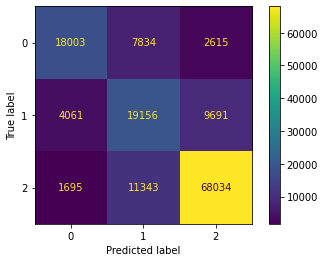

In [ ]:
y_val_pred = best_model.predict(rev_val['review'])
print("Accuracy on Val dataset = ", metrics.accuracy_score(y_val, y_val_pred))

print("Validation Report:")
print(metrics.classification_report(y_val, y_val_pred))

cm = metrics.confusion_matrix(y_val, y_val_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Accuracy on Test dataset =  0.7365967694235942
Test Data Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.65      0.70     28284
     Neutral       0.50      0.57      0.54     33475
    Positive       0.84      0.84      0.84     80259

    accuracy                           0.74    142018
   macro avg       0.70      0.69      0.69    142018
weighted avg       0.75      0.74      0.74    142018



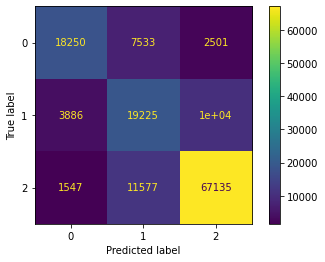

In [ ]:
y_test_pred = best_model.predict(rev_test['review'])
print("Accuracy on Test dataset = ", metrics.accuracy_score(y_test, y_test_pred))

print("Test Data Classification Report:")
print(metrics.classification_report(y_test, y_test_pred))

cm = metrics.confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()